In [1]:
import random

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils import data
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.utils as vutils
from torchvision.utils import make_grid
import os

import scipy.io

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from classify_svhn import *

# SET UP

In [2]:
# train_path = "drive/My Drive/Colab Notebooks/IFT6135_ApprentissageRepresentations/hw3/train_32x32.mat"
# test_path = "drive/My Drive/Colab Notebooks/IFT6135_ApprentissageRepresentations/hw3/test_32x32.mat"

train_path = "train_32x32.mat"
test_path = "test_32x32.mat"

In [3]:
# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

cuda


# DATA

In [4]:
def make_dataloaders(train_file,test_file,split_size=0.20,batch_size=16,transform=None):
    
    traindata = scipy.io.loadmat(train_file)
    testdata = scipy.io.loadmat(test_file)
    
    X = traindata['X']  
    X = X.T
    
    X_test = testdata['X']
    X_test = X_test.T
    
    X_train, X_valid =  train_test_split( X, test_size=split_size, random_state=42)
    
    train_dataset = SVHN_dataset(X_train,transform)
    valid_dataset = SVHN_dataset(X_valid,transform)
    test_dataset = SVHN_dataset(X_test,transform)
    
    train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=4)

    valid_loader = DataLoader(valid_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=4)
    
    test_loader = DataLoader(test_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=4)
    
    return train_loader, valid_loader, test_loader

In [5]:
class SVHN_dataset(data.Dataset):
 
    def __init__(self, images, transform=None):
        'Initialization'
        self.images = images
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        image = self.images[index,:,:,:]
        
        sample = image.T

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
to_tensor = transforms.ToTensor()
normalize= transforms.Normalize((.5, .5, .5),(.5, .5, .5))

# Declare transformations

transform = transforms.Compose([to_tensor,
                               normalize])

In [7]:
bsize = 32
train_loader,valid_loader,test_loader = make_dataloaders(train_path,test_path,
                                                         split_size=0.20,
                                                         batch_size=bsize,
                                                         transform=transform)

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# DISCRIMINATOR

In [9]:

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input size is 3x32x32
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1,bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 32x32x32
            nn.Conv2d(32, 64, 4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 64x16x16
            nn.Conv2d(64, 256, 4, 2, 1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0,bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(64, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# GENERATOR

In [11]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 16 x 16
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. 32 x 32 x 32
            nn.ConvTranspose2d(32, 3, 3, 1, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [13]:
def show(img,epoch,path):
    title = "GAN_epoch{}.png".format(epoch)
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest', aspect='auto')
    plt.tight_layout()
    plt.savefig(os.path.join(path, title),dpi=300)

# TRAIN

Starting Training Loop...
[0/50][0/1832]	Loss_D: 1.4196	Loss_G: 4.5757	D(x): 0.4459	D(G(z)): 0.3506 / 0.0120
[0/50][50/1832]	Loss_D: 0.0551	Loss_G: 8.3207	D(x): 0.9876	D(G(z)): 0.0402 / 0.0003
[0/50][100/1832]	Loss_D: 0.0821	Loss_G: 5.7230	D(x): 0.9867	D(G(z)): 0.0655 / 0.0043
[0/50][150/1832]	Loss_D: 0.3529	Loss_G: 4.0709	D(x): 0.8303	D(G(z)): 0.1036 / 0.0267
[0/50][200/1832]	Loss_D: 0.3421	Loss_G: 8.7348	D(x): 0.9226	D(G(z)): 0.1712 / 0.0004
[0/50][250/1832]	Loss_D: 0.4728	Loss_G: 7.0745	D(x): 0.7355	D(G(z)): 0.0034 / 0.0139
[0/50][300/1832]	Loss_D: 0.1127	Loss_G: 7.7596	D(x): 0.9778	D(G(z)): 0.0744 / 0.0006
[0/50][350/1832]	Loss_D: 0.1899	Loss_G: 7.2999	D(x): 0.8552	D(G(z)): 0.0041 / 0.0014
[0/50][400/1832]	Loss_D: 0.2596	Loss_G: 6.1720	D(x): 0.8404	D(G(z)): 0.0098 / 0.0077
[0/50][450/1832]	Loss_D: 0.0588	Loss_G: 5.1858	D(x): 0.9873	D(G(z)): 0.0441 / 0.0067
[0/50][500/1832]	Loss_D: 0.0280	Loss_G: 5.5358	D(x): 0.9798	D(G(z)): 0.0060 / 0.0048
[0/50][550/1832]	Loss_D: 0.2662	Loss_G: 6.

[2/50][1100/1832]	Loss_D: 0.6212	Loss_G: 3.4793	D(x): 0.7502	D(G(z)): 0.2014 / 0.0439
[2/50][1150/1832]	Loss_D: 0.8492	Loss_G: 1.4876	D(x): 0.7063	D(G(z)): 0.3244 / 0.2603
[2/50][1200/1832]	Loss_D: 0.5651	Loss_G: 2.3829	D(x): 0.6560	D(G(z)): 0.0761 / 0.1248
[2/50][1250/1832]	Loss_D: 0.2529	Loss_G: 3.7004	D(x): 0.8911	D(G(z)): 0.1106 / 0.0376
[2/50][1300/1832]	Loss_D: 0.8533	Loss_G: 4.9385	D(x): 0.9040	D(G(z)): 0.4624 / 0.0137
[2/50][1350/1832]	Loss_D: 0.7567	Loss_G: 3.2147	D(x): 0.8971	D(G(z)): 0.4383 / 0.0556
[2/50][1400/1832]	Loss_D: 0.4306	Loss_G: 1.9860	D(x): 0.8093	D(G(z)): 0.1710 / 0.1762
[2/50][1450/1832]	Loss_D: 0.4307	Loss_G: 3.2783	D(x): 0.7861	D(G(z)): 0.1305 / 0.0607
[2/50][1500/1832]	Loss_D: 0.6509	Loss_G: 2.4134	D(x): 0.8154	D(G(z)): 0.3076 / 0.1338
[2/50][1550/1832]	Loss_D: 0.6053	Loss_G: 3.0960	D(x): 0.9416	D(G(z)): 0.3586 / 0.0858
[2/50][1600/1832]	Loss_D: 0.3584	Loss_G: 2.8989	D(x): 0.7710	D(G(z)): 0.0586 / 0.0848
[2/50][1650/1832]	Loss_D: 0.3090	Loss_G: 3.8974	D(x): 

[5/50][350/1832]	Loss_D: 0.3922	Loss_G: 3.9171	D(x): 0.9307	D(G(z)): 0.2464 / 0.0318
[5/50][400/1832]	Loss_D: 0.7133	Loss_G: 3.2875	D(x): 0.5753	D(G(z)): 0.0442 / 0.0672
[5/50][450/1832]	Loss_D: 0.5308	Loss_G: 3.7109	D(x): 0.8357	D(G(z)): 0.2556 / 0.0398
[5/50][500/1832]	Loss_D: 0.4358	Loss_G: 2.8199	D(x): 0.7526	D(G(z)): 0.0846 / 0.1006
[5/50][550/1832]	Loss_D: 0.3171	Loss_G: 2.8590	D(x): 0.8243	D(G(z)): 0.0971 / 0.1086
[5/50][600/1832]	Loss_D: 0.4405	Loss_G: 2.8323	D(x): 0.8222	D(G(z)): 0.1956 / 0.0798
[5/50][650/1832]	Loss_D: 0.8559	Loss_G: 1.9422	D(x): 0.5230	D(G(z)): 0.1028 / 0.2243
[5/50][700/1832]	Loss_D: 0.5033	Loss_G: 3.2460	D(x): 0.8563	D(G(z)): 0.2440 / 0.0549
[5/50][750/1832]	Loss_D: 0.3258	Loss_G: 2.6469	D(x): 0.8782	D(G(z)): 0.1538 / 0.1002
[5/50][800/1832]	Loss_D: 0.5446	Loss_G: 3.3134	D(x): 0.8557	D(G(z)): 0.2532 / 0.0601
[5/50][850/1832]	Loss_D: 1.0647	Loss_G: 5.4012	D(x): 0.9773	D(G(z)): 0.5527 / 0.0093
[5/50][900/1832]	Loss_D: 0.5286	Loss_G: 2.2119	D(x): 0.7435	D(G(z

[7/50][1450/1832]	Loss_D: 1.2632	Loss_G: 2.4829	D(x): 0.3759	D(G(z)): 0.0114 / 0.1320
[7/50][1500/1832]	Loss_D: 0.2213	Loss_G: 3.8589	D(x): 0.9034	D(G(z)): 0.0952 / 0.0449
[7/50][1550/1832]	Loss_D: 1.1706	Loss_G: 2.1142	D(x): 0.4444	D(G(z)): 0.0452 / 0.1670
[7/50][1600/1832]	Loss_D: 0.3799	Loss_G: 2.2721	D(x): 0.7575	D(G(z)): 0.0640 / 0.1511
[7/50][1650/1832]	Loss_D: 0.0552	Loss_G: 5.4684	D(x): 0.9652	D(G(z)): 0.0187 / 0.0122
[7/50][1700/1832]	Loss_D: 0.3723	Loss_G: 4.4248	D(x): 0.9506	D(G(z)): 0.2075 / 0.0242
[7/50][1750/1832]	Loss_D: 0.3538	Loss_G: 2.6647	D(x): 0.8369	D(G(z)): 0.1359 / 0.1030
[7/50][1800/1832]	Loss_D: 0.2291	Loss_G: 4.0507	D(x): 0.9860	D(G(z)): 0.1613 / 0.0269
[8/50][0/1832]	Loss_D: 0.8444	Loss_G: 3.2204	D(x): 0.5259	D(G(z)): 0.0098 / 0.0822
[8/50][50/1832]	Loss_D: 0.2422	Loss_G: 4.9457	D(x): 0.9205	D(G(z)): 0.1340 / 0.0140
[8/50][100/1832]	Loss_D: 0.3723	Loss_G: 5.3364	D(x): 0.9479	D(G(z)): 0.2100 / 0.0089
[8/50][150/1832]	Loss_D: 0.2892	Loss_G: 1.6063	D(x): 0.9517	

[10/50][700/1832]	Loss_D: 0.1323	Loss_G: 4.1714	D(x): 0.9611	D(G(z)): 0.0824 / 0.0269
[10/50][750/1832]	Loss_D: 0.3264	Loss_G: 3.1030	D(x): 0.8751	D(G(z)): 0.1399 / 0.0841
[10/50][800/1832]	Loss_D: 0.9010	Loss_G: 2.3409	D(x): 0.4974	D(G(z)): 0.0541 / 0.2069
[10/50][850/1832]	Loss_D: 0.4437	Loss_G: 3.6265	D(x): 0.8436	D(G(z)): 0.1972 / 0.0509
[10/50][900/1832]	Loss_D: 0.3545	Loss_G: 2.4462	D(x): 0.8167	D(G(z)): 0.1145 / 0.1543
[10/50][950/1832]	Loss_D: 0.6191	Loss_G: 1.6584	D(x): 0.6285	D(G(z)): 0.0367 / 0.2837
[10/50][1000/1832]	Loss_D: 0.4621	Loss_G: 3.9210	D(x): 0.9162	D(G(z)): 0.2719 / 0.0347
[10/50][1050/1832]	Loss_D: 1.0959	Loss_G: 5.9373	D(x): 0.9949	D(G(z)): 0.5788 / 0.0055
[10/50][1100/1832]	Loss_D: 0.2455	Loss_G: 3.7538	D(x): 0.8754	D(G(z)): 0.0882 / 0.0470
[10/50][1150/1832]	Loss_D: 0.2239	Loss_G: 3.2826	D(x): 0.8416	D(G(z)): 0.0286 / 0.0701
[10/50][1200/1832]	Loss_D: 0.2518	Loss_G: 4.4354	D(x): 0.9801	D(G(z)): 0.1899 / 0.0181
[10/50][1250/1832]	Loss_D: 0.1792	Loss_G: 3.6418	

[12/50][1750/1832]	Loss_D: 0.5690	Loss_G: 5.4815	D(x): 0.8970	D(G(z)): 0.3194 / 0.0102
[12/50][1800/1832]	Loss_D: 0.7075	Loss_G: 6.7948	D(x): 0.9956	D(G(z)): 0.3679 / 0.0021
[13/50][0/1832]	Loss_D: 0.3476	Loss_G: 2.4270	D(x): 0.8003	D(G(z)): 0.0848 / 0.1271
[13/50][50/1832]	Loss_D: 0.1612	Loss_G: 4.3056	D(x): 0.9687	D(G(z)): 0.1145 / 0.0216
[13/50][100/1832]	Loss_D: 0.1374	Loss_G: 5.5487	D(x): 0.9292	D(G(z)): 0.0158 / 0.0138
[13/50][150/1832]	Loss_D: 1.0210	Loss_G: 5.1831	D(x): 0.9821	D(G(z)): 0.5155 / 0.0122
[13/50][200/1832]	Loss_D: 0.2880	Loss_G: 4.0693	D(x): 0.9437	D(G(z)): 0.1802 / 0.0356
[13/50][250/1832]	Loss_D: 0.3267	Loss_G: 2.9988	D(x): 0.9920	D(G(z)): 0.2168 / 0.0825
[13/50][300/1832]	Loss_D: 0.1681	Loss_G: 4.7596	D(x): 0.9841	D(G(z)): 0.1315 / 0.0230
[13/50][350/1832]	Loss_D: 0.1337	Loss_G: 3.6263	D(x): 0.9324	D(G(z)): 0.0588 / 0.0634
[13/50][400/1832]	Loss_D: 0.1440	Loss_G: 4.1241	D(x): 0.9090	D(G(z)): 0.0399 / 0.0248
[13/50][450/1832]	Loss_D: 0.2363	Loss_G: 5.3067	D(x): 0

[15/50][950/1832]	Loss_D: 0.6374	Loss_G: 3.5991	D(x): 0.6744	D(G(z)): 0.1018 / 0.0825
[15/50][1000/1832]	Loss_D: 0.4277	Loss_G: 3.3816	D(x): 0.8092	D(G(z)): 0.1252 / 0.0553
[15/50][1050/1832]	Loss_D: 0.1272	Loss_G: 4.6250	D(x): 0.9687	D(G(z)): 0.0837 / 0.0220
[15/50][1100/1832]	Loss_D: 0.2143	Loss_G: 4.5757	D(x): 0.8419	D(G(z)): 0.0252 / 0.0295
[15/50][1150/1832]	Loss_D: 0.5033	Loss_G: 2.7410	D(x): 0.7279	D(G(z)): 0.0561 / 0.1078
[15/50][1200/1832]	Loss_D: 0.3511	Loss_G: 5.5182	D(x): 0.7433	D(G(z)): 0.0041 / 0.0075
[15/50][1250/1832]	Loss_D: 0.2045	Loss_G: 3.8785	D(x): 0.8811	D(G(z)): 0.0295 / 0.0351
[15/50][1300/1832]	Loss_D: 0.1455	Loss_G: 4.9082	D(x): 0.9046	D(G(z)): 0.0368 / 0.0166
[15/50][1350/1832]	Loss_D: 0.2827	Loss_G: 4.4390	D(x): 0.9778	D(G(z)): 0.2061 / 0.0243
[15/50][1400/1832]	Loss_D: 0.7859	Loss_G: 5.3400	D(x): 0.8591	D(G(z)): 0.4026 / 0.0100
[15/50][1450/1832]	Loss_D: 0.0976	Loss_G: 6.1754	D(x): 0.9220	D(G(z)): 0.0131 / 0.0045
[15/50][1500/1832]	Loss_D: 0.2387	Loss_G: 6.

[18/50][150/1832]	Loss_D: 0.1789	Loss_G: 3.9478	D(x): 0.9324	D(G(z)): 0.0916 / 0.0426
[18/50][200/1832]	Loss_D: 0.3164	Loss_G: 5.8683	D(x): 0.7879	D(G(z)): 0.0053 / 0.0130
[18/50][250/1832]	Loss_D: 0.1428	Loss_G: 4.6338	D(x): 0.9555	D(G(z)): 0.0800 / 0.0203
[18/50][300/1832]	Loss_D: 0.1255	Loss_G: 4.7425	D(x): 0.9084	D(G(z)): 0.0219 / 0.0185
[18/50][350/1832]	Loss_D: 0.1963	Loss_G: 3.6957	D(x): 0.9528	D(G(z)): 0.1154 / 0.0365
[18/50][400/1832]	Loss_D: 0.4809	Loss_G: 3.1073	D(x): 0.7369	D(G(z)): 0.0491 / 0.1022
[18/50][450/1832]	Loss_D: 0.1579	Loss_G: 4.7312	D(x): 0.9050	D(G(z)): 0.0335 / 0.0189
[18/50][500/1832]	Loss_D: 0.2994	Loss_G: 4.7492	D(x): 0.8048	D(G(z)): 0.0341 / 0.0171
[18/50][550/1832]	Loss_D: 0.0388	Loss_G: 5.2624	D(x): 0.9691	D(G(z)): 0.0060 / 0.0113
[18/50][600/1832]	Loss_D: 0.1932	Loss_G: 2.8118	D(x): 0.9109	D(G(z)): 0.0827 / 0.0927
[18/50][650/1832]	Loss_D: 0.2463	Loss_G: 4.1834	D(x): 0.8215	D(G(z)): 0.0129 / 0.0506
[18/50][700/1832]	Loss_D: 0.2899	Loss_G: 4.2581	D(x): 

[20/50][1200/1832]	Loss_D: 0.3101	Loss_G: 4.4850	D(x): 0.7694	D(G(z)): 0.0048 / 0.0286
[20/50][1250/1832]	Loss_D: 0.2911	Loss_G: 4.6722	D(x): 0.9739	D(G(z)): 0.1294 / 0.0228
[20/50][1300/1832]	Loss_D: 0.1792	Loss_G: 4.8424	D(x): 0.9626	D(G(z)): 0.1041 / 0.0229
[20/50][1350/1832]	Loss_D: 0.6280	Loss_G: 6.9398	D(x): 0.9656	D(G(z)): 0.2821 / 0.0062
[20/50][1400/1832]	Loss_D: 0.6759	Loss_G: 3.9269	D(x): 0.7009	D(G(z)): 0.0081 / 0.0537
[20/50][1450/1832]	Loss_D: 0.2004	Loss_G: 5.5774	D(x): 0.8521	D(G(z)): 0.0127 / 0.0123
[20/50][1500/1832]	Loss_D: 0.1938	Loss_G: 4.2712	D(x): 0.8941	D(G(z)): 0.0538 / 0.0361
[20/50][1550/1832]	Loss_D: 0.3828	Loss_G: 5.5530	D(x): 0.9256	D(G(z)): 0.1543 / 0.0148
[20/50][1600/1832]	Loss_D: 0.3454	Loss_G: 4.5323	D(x): 0.7562	D(G(z)): 0.0368 / 0.0298
[20/50][1650/1832]	Loss_D: 0.0900	Loss_G: 5.7554	D(x): 0.9297	D(G(z)): 0.0075 / 0.0134
[20/50][1700/1832]	Loss_D: 0.1892	Loss_G: 3.7650	D(x): 0.8670	D(G(z)): 0.0277 / 0.0436
[20/50][1750/1832]	Loss_D: 0.1604	Loss_G: 4

/miniconda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[21/50][0/1832]	Loss_D: 0.1701	Loss_G: 4.4803	D(x): 0.9644	D(G(z)): 0.1136 / 0.0218
[21/50][50/1832]	Loss_D: 0.3265	Loss_G: 3.8863	D(x): 0.7866	D(G(z)): 0.0042 / 0.0392
[21/50][100/1832]	Loss_D: 0.1174	Loss_G: 4.8598	D(x): 0.9695	D(G(z)): 0.0712 / 0.0197
[21/50][150/1832]	Loss_D: 0.4157	Loss_G: 3.2143	D(x): 0.6982	D(G(z)): 0.0094 / 0.0820
[21/50][200/1832]	Loss_D: 0.0359	Loss_G: 5.9428	D(x): 0.9794	D(G(z)): 0.0143 / 0.0096
[21/50][250/1832]	Loss_D: 0.0937	Loss_G: 3.9946	D(x): 0.9695	D(G(z)): 0.0552 / 0.0746
[21/50][300/1832]	Loss_D: 0.0660	Loss_G: 6.1072	D(x): 0.9426	D(G(z)): 0.0050 / 0.0072
[21/50][350/1832]	Loss_D: 0.1915	Loss_G: 5.1125	D(x): 0.9697	D(G(z)): 0.1296 / 0.0179
[21/50][400/1832]	Loss_D: 0.3313	Loss_G: 2.6913	D(x): 0.9060	D(G(z)): 0.0911 / 0.0906
[21/50][450/1832]	Loss_D: 0.1462	Loss_G: 3.9896	D(x): 0.8955	D(G(z)): 0.0251 / 0.0409
[21/50][500/1832]	Loss_D: 0.1733	Loss_G: 4.2663	D(x): 0.8942	D(G(z)): 0.0464 / 0.0268
[21/50][550/1832]	Loss_D: 0.2992	Loss_G: 4.7144	D(x): 0.7

[23/50][1050/1832]	Loss_D: 0.0839	Loss_G: 5.1342	D(x): 0.9986	D(G(z)): 0.0745 / 0.0151
[23/50][1100/1832]	Loss_D: 0.4045	Loss_G: 6.0434	D(x): 0.9926	D(G(z)): 0.2765 / 0.0040
[23/50][1150/1832]	Loss_D: 0.7284	Loss_G: 2.2325	D(x): 0.6396	D(G(z)): 0.0194 / 0.2903
[23/50][1200/1832]	Loss_D: 0.3795	Loss_G: 6.2142	D(x): 0.9399	D(G(z)): 0.2364 / 0.0043
[23/50][1250/1832]	Loss_D: 0.1352	Loss_G: 4.7927	D(x): 0.9244	D(G(z)): 0.0388 / 0.0180
[23/50][1300/1832]	Loss_D: 0.1077	Loss_G: 4.9610	D(x): 0.9417	D(G(z)): 0.0402 / 0.0303
[23/50][1350/1832]	Loss_D: 0.1051	Loss_G: 4.6525	D(x): 0.9470	D(G(z)): 0.0457 / 0.0309
[23/50][1400/1832]	Loss_D: 0.0521	Loss_G: 4.3178	D(x): 0.9922	D(G(z)): 0.0421 / 0.0316
[23/50][1450/1832]	Loss_D: 0.0843	Loss_G: 4.7353	D(x): 0.9377	D(G(z)): 0.0122 / 0.0300
[23/50][1500/1832]	Loss_D: 0.0599	Loss_G: 5.7486	D(x): 0.9718	D(G(z)): 0.0268 / 0.0137
[23/50][1550/1832]	Loss_D: 0.5979	Loss_G: 6.8442	D(x): 0.6517	D(G(z)): 0.0005 / 0.0046
[23/50][1600/1832]	Loss_D: 0.1630	Loss_G: 3

[26/50][250/1832]	Loss_D: 0.1087	Loss_G: 5.2948	D(x): 0.9140	D(G(z)): 0.0121 / 0.0208
[26/50][300/1832]	Loss_D: 0.0812	Loss_G: 5.7328	D(x): 0.9332	D(G(z)): 0.0086 / 0.0114
[26/50][350/1832]	Loss_D: 0.0904	Loss_G: 5.0418	D(x): 0.9294	D(G(z)): 0.0123 / 0.0198
[26/50][400/1832]	Loss_D: 0.3308	Loss_G: 5.8155	D(x): 0.7577	D(G(z)): 0.0009 / 0.0132
[26/50][450/1832]	Loss_D: 0.3061	Loss_G: 6.8908	D(x): 0.7734	D(G(z)): 0.0108 / 0.0066
[26/50][500/1832]	Loss_D: 0.0538	Loss_G: 6.0949	D(x): 0.9554	D(G(z)): 0.0063 / 0.0070
[26/50][550/1832]	Loss_D: 0.0758	Loss_G: 5.8723	D(x): 0.9433	D(G(z)): 0.0110 / 0.0093
[26/50][600/1832]	Loss_D: 0.2299	Loss_G: 4.1670	D(x): 0.8526	D(G(z)): 0.0344 / 0.0466
[26/50][650/1832]	Loss_D: 0.2331	Loss_G: 4.1590	D(x): 0.8539	D(G(z)): 0.0200 / 0.0364
[26/50][700/1832]	Loss_D: 0.0428	Loss_G: 6.8722	D(x): 0.9672	D(G(z)): 0.0085 / 0.0030
[26/50][750/1832]	Loss_D: 0.4771	Loss_G: 4.6873	D(x): 0.7483	D(G(z)): 0.0052 / 0.0520
[26/50][800/1832]	Loss_D: 0.2593	Loss_G: 5.0345	D(x): 

[28/50][1300/1832]	Loss_D: 0.1577	Loss_G: 4.2552	D(x): 0.9196	D(G(z)): 0.0614 / 0.0294
[28/50][1350/1832]	Loss_D: 0.4233	Loss_G: 2.7117	D(x): 0.7430	D(G(z)): 0.0537 / 0.1492
[28/50][1400/1832]	Loss_D: 0.1287	Loss_G: 3.4565	D(x): 0.9256	D(G(z)): 0.0226 / 0.0503
[28/50][1450/1832]	Loss_D: 0.0640	Loss_G: 5.7885	D(x): 0.9920	D(G(z)): 0.0526 / 0.0091
[28/50][1500/1832]	Loss_D: 0.3669	Loss_G: 7.1298	D(x): 0.9865	D(G(z)): 0.2348 / 0.0025
[28/50][1550/1832]	Loss_D: 0.1589	Loss_G: 6.4664	D(x): 0.9587	D(G(z)): 0.0595 / 0.0050
[28/50][1600/1832]	Loss_D: 0.0907	Loss_G: 4.9459	D(x): 0.9389	D(G(z)): 0.0202 / 0.0210
[28/50][1650/1832]	Loss_D: 0.2275	Loss_G: 5.6165	D(x): 0.9668	D(G(z)): 0.0702 / 0.0135
[28/50][1700/1832]	Loss_D: 0.3357	Loss_G: 4.2434	D(x): 0.8410	D(G(z)): 0.1034 / 0.0454
[28/50][1750/1832]	Loss_D: 0.0977	Loss_G: 5.8750	D(x): 0.9821	D(G(z)): 0.0733 / 0.0061
[28/50][1800/1832]	Loss_D: 0.0356	Loss_G: 4.4171	D(x): 0.9944	D(G(z)): 0.0288 / 0.0231
[29/50][0/1832]	Loss_D: 0.0970	Loss_G: 5.07

[31/50][500/1832]	Loss_D: 0.0948	Loss_G: 5.7708	D(x): 0.9438	D(G(z)): 0.0274 / 0.0138
[31/50][550/1832]	Loss_D: 0.0075	Loss_G: 8.0020	D(x): 0.9945	D(G(z)): 0.0020 / 0.0013
[31/50][600/1832]	Loss_D: 0.1578	Loss_G: 5.1510	D(x): 0.9707	D(G(z)): 0.1098 / 0.0147
[31/50][650/1832]	Loss_D: 0.1213	Loss_G: 5.2797	D(x): 0.9450	D(G(z)): 0.0493 / 0.0136
[31/50][700/1832]	Loss_D: 0.0568	Loss_G: 6.4510	D(x): 0.9778	D(G(z)): 0.0274 / 0.0075
[31/50][750/1832]	Loss_D: 0.1890	Loss_G: 4.9367	D(x): 0.9681	D(G(z)): 0.1275 / 0.0154
[31/50][800/1832]	Loss_D: 0.1155	Loss_G: 5.2100	D(x): 0.9670	D(G(z)): 0.0629 / 0.0193
[31/50][850/1832]	Loss_D: 0.0374	Loss_G: 5.8990	D(x): 0.9702	D(G(z)): 0.0060 / 0.0085
[31/50][900/1832]	Loss_D: 0.2568	Loss_G: 4.8309	D(x): 0.9352	D(G(z)): 0.1131 / 0.0172
[31/50][950/1832]	Loss_D: 0.1668	Loss_G: 4.6950	D(x): 0.8700	D(G(z)): 0.0157 / 0.0295
[31/50][1000/1832]	Loss_D: 0.0689	Loss_G: 5.0304	D(x): 0.9622	D(G(z)): 0.0214 / 0.0223
[31/50][1050/1832]	Loss_D: 0.0911	Loss_G: 5.0938	D(x)

[33/50][1550/1832]	Loss_D: 0.1176	Loss_G: 5.8547	D(x): 0.9075	D(G(z)): 0.0117 / 0.0134
[33/50][1600/1832]	Loss_D: 0.1270	Loss_G: 4.8393	D(x): 0.9399	D(G(z)): 0.0497 / 0.0242
[33/50][1650/1832]	Loss_D: 0.2462	Loss_G: 8.4266	D(x): 0.9261	D(G(z)): 0.0485 / 0.0017
[33/50][1700/1832]	Loss_D: 0.0617	Loss_G: 3.7285	D(x): 0.9818	D(G(z)): 0.0379 / 0.0775
[33/50][1750/1832]	Loss_D: 0.1022	Loss_G: 5.1118	D(x): 0.9324	D(G(z)): 0.0256 / 0.0200
[33/50][1800/1832]	Loss_D: 0.0882	Loss_G: 5.4638	D(x): 0.9928	D(G(z)): 0.0665 / 0.0114
[34/50][0/1832]	Loss_D: 0.0964	Loss_G: 5.2358	D(x): 0.9308	D(G(z)): 0.0169 / 0.0238
[34/50][50/1832]	Loss_D: 0.0813	Loss_G: 5.8495	D(x): 0.9595	D(G(z)): 0.0344 / 0.0160
[34/50][100/1832]	Loss_D: 0.0264	Loss_G: 6.8923	D(x): 0.9854	D(G(z)): 0.0114 / 0.0036
[34/50][150/1832]	Loss_D: 0.1653	Loss_G: 4.6427	D(x): 0.9525	D(G(z)): 0.0742 / 0.0314
[34/50][200/1832]	Loss_D: 0.0942	Loss_G: 5.3632	D(x): 0.9240	D(G(z)): 0.0072 / 0.0140
[34/50][250/1832]	Loss_D: 0.2706	Loss_G: 4.4170	D(x

[36/50][750/1832]	Loss_D: 0.1275	Loss_G: 5.5717	D(x): 0.9203	D(G(z)): 0.0334 / 0.0164
[36/50][800/1832]	Loss_D: 0.1159	Loss_G: 3.8923	D(x): 0.9131	D(G(z)): 0.0100 / 0.0591
[36/50][850/1832]	Loss_D: 0.3203	Loss_G: 6.3937	D(x): 0.9937	D(G(z)): 0.1781 / 0.0085
[36/50][900/1832]	Loss_D: 0.0898	Loss_G: 5.5654	D(x): 0.9334	D(G(z)): 0.0172 / 0.0165
[36/50][950/1832]	Loss_D: 0.1777	Loss_G: 5.9669	D(x): 0.8679	D(G(z)): 0.0064 / 0.0143
[36/50][1000/1832]	Loss_D: 0.0321	Loss_G: 6.0665	D(x): 0.9758	D(G(z)): 0.0071 / 0.0086
[36/50][1050/1832]	Loss_D: 0.0063	Loss_G: 7.6529	D(x): 0.9974	D(G(z)): 0.0036 / 0.0027
[36/50][1100/1832]	Loss_D: 0.0639	Loss_G: 7.1769	D(x): 0.9797	D(G(z)): 0.0387 / 0.0038
[36/50][1150/1832]	Loss_D: 0.2680	Loss_G: 2.8570	D(x): 0.8478	D(G(z)): 0.0538 / 0.1625
[36/50][1200/1832]	Loss_D: 0.1621	Loss_G: 5.1202	D(x): 0.9043	D(G(z)): 0.0256 / 0.0143
[36/50][1250/1832]	Loss_D: 0.0798	Loss_G: 5.3725	D(x): 0.9645	D(G(z)): 0.0377 / 0.0189
[36/50][1300/1832]	Loss_D: 0.0589	Loss_G: 6.1508

[38/50][1800/1832]	Loss_D: 0.0465	Loss_G: 5.6278	D(x): 0.9946	D(G(z)): 0.0389 / 0.0115
[39/50][0/1832]	Loss_D: 0.0512	Loss_G: 5.7165	D(x): 0.9964	D(G(z)): 0.0442 / 0.0076
[39/50][50/1832]	Loss_D: 0.0090	Loss_G: 7.1727	D(x): 0.9954	D(G(z)): 0.0044 / 0.0033
[39/50][100/1832]	Loss_D: 0.2076	Loss_G: 8.7166	D(x): 0.8275	D(G(z)): 0.0004 / 0.0010
[39/50][150/1832]	Loss_D: 0.0847	Loss_G: 7.2112	D(x): 0.9253	D(G(z)): 0.0041 / 0.0064
[39/50][200/1832]	Loss_D: 0.0818	Loss_G: 5.8517	D(x): 0.9785	D(G(z)): 0.0509 / 0.0120
[39/50][250/1832]	Loss_D: 0.2514	Loss_G: 6.0558	D(x): 0.8932	D(G(z)): 0.0515 / 0.0139
[39/50][300/1832]	Loss_D: 0.0543	Loss_G: 8.4259	D(x): 0.9508	D(G(z)): 0.0014 / 0.0015
[39/50][350/1832]	Loss_D: 0.0220	Loss_G: 7.2548	D(x): 0.9840	D(G(z)): 0.0053 / 0.0033
[39/50][400/1832]	Loss_D: 0.0883	Loss_G: 6.0301	D(x): 0.9967	D(G(z)): 0.0775 / 0.0057
[39/50][450/1832]	Loss_D: 0.6410	Loss_G: 11.4956	D(x): 0.9933	D(G(z)): 0.2642 / 0.0002
[39/50][500/1832]	Loss_D: 0.0564	Loss_G: 6.6736	D(x): 0

[41/50][1000/1832]	Loss_D: 0.1575	Loss_G: 5.1238	D(x): 0.8980	D(G(z)): 0.0329 / 0.0245
[41/50][1050/1832]	Loss_D: 0.1520	Loss_G: 6.1297	D(x): 1.0000	D(G(z)): 0.1173 / 0.0055
[41/50][1100/1832]	Loss_D: 0.1250	Loss_G: 4.9260	D(x): 0.9465	D(G(z)): 0.0590 / 0.0224
[41/50][1150/1832]	Loss_D: 0.0685	Loss_G: 6.1254	D(x): 0.9469	D(G(z)): 0.0104 / 0.0111
[41/50][1200/1832]	Loss_D: 0.3051	Loss_G: 5.9667	D(x): 0.8148	D(G(z)): 0.0061 / 0.0143
[41/50][1250/1832]	Loss_D: 0.1123	Loss_G: 7.2418	D(x): 0.9237	D(G(z)): 0.0030 / 0.0045
[41/50][1300/1832]	Loss_D: 0.0871	Loss_G: 4.8028	D(x): 0.9506	D(G(z)): 0.0325 / 0.0205
[41/50][1350/1832]	Loss_D: 0.1403	Loss_G: 4.6996	D(x): 0.9970	D(G(z)): 0.1015 / 0.0150
[41/50][1400/1832]	Loss_D: 0.0686	Loss_G: 4.8842	D(x): 0.9518	D(G(z)): 0.0163 / 0.0246
[41/50][1450/1832]	Loss_D: 0.1751	Loss_G: 6.9435	D(x): 0.8826	D(G(z)): 0.0043 / 0.0098
[41/50][1500/1832]	Loss_D: 0.0881	Loss_G: 5.8262	D(x): 0.9465	D(G(z)): 0.0245 / 0.0212
[41/50][1550/1832]	Loss_D: 0.0744	Loss_G: 5

[44/50][200/1832]	Loss_D: 0.1104	Loss_G: 6.1949	D(x): 0.9895	D(G(z)): 0.0887 / 0.0052
[44/50][250/1832]	Loss_D: 0.0825	Loss_G: 5.2093	D(x): 0.9393	D(G(z)): 0.0085 / 0.0141
[44/50][300/1832]	Loss_D: 0.0721	Loss_G: 6.4507	D(x): 0.9972	D(G(z)): 0.0491 / 0.0055
[44/50][350/1832]	Loss_D: 0.2315	Loss_G: 5.2796	D(x): 0.8208	D(G(z)): 0.0031 / 0.0288
[44/50][400/1832]	Loss_D: 0.1910	Loss_G: 6.0222	D(x): 0.9204	D(G(z)): 0.0717 / 0.0141
[44/50][450/1832]	Loss_D: 0.0349	Loss_G: 5.9723	D(x): 0.9791	D(G(z)): 0.0095 / 0.0081
[44/50][500/1832]	Loss_D: 0.0793	Loss_G: 6.2781	D(x): 0.9647	D(G(z)): 0.0336 / 0.0066
[44/50][550/1832]	Loss_D: 0.1088	Loss_G: 5.1618	D(x): 0.9751	D(G(z)): 0.0741 / 0.0169
[44/50][600/1832]	Loss_D: 0.0389	Loss_G: 7.2955	D(x): 0.9753	D(G(z)): 0.0127 / 0.0055
[44/50][650/1832]	Loss_D: 0.1087	Loss_G: 5.5577	D(x): 0.9341	D(G(z)): 0.0329 / 0.0143
[44/50][700/1832]	Loss_D: 0.0226	Loss_G: 7.1862	D(x): 0.9814	D(G(z)): 0.0035 / 0.0070
[44/50][750/1832]	Loss_D: 0.1679	Loss_G: 5.9678	D(x): 

[46/50][1250/1832]	Loss_D: 0.0409	Loss_G: 7.5158	D(x): 0.9642	D(G(z)): 0.0027 / 0.0030
[46/50][1300/1832]	Loss_D: 0.0579	Loss_G: 5.9438	D(x): 0.9933	D(G(z)): 0.0475 / 0.0083
[46/50][1350/1832]	Loss_D: 0.0319	Loss_G: 5.1589	D(x): 0.9866	D(G(z)): 0.0177 / 0.0173
[46/50][1400/1832]	Loss_D: 0.0585	Loss_G: 6.0435	D(x): 0.9929	D(G(z)): 0.0477 / 0.0157
[46/50][1450/1832]	Loss_D: 0.0515	Loss_G: 6.4227	D(x): 0.9942	D(G(z)): 0.0425 / 0.0061
[46/50][1500/1832]	Loss_D: 0.3226	Loss_G: 6.8992	D(x): 0.7923	D(G(z)): 0.0131 / 0.0085
[46/50][1550/1832]	Loss_D: 0.1700	Loss_G: 7.4596	D(x): 0.8909	D(G(z)): 0.0011 / 0.0037
[46/50][1600/1832]	Loss_D: 0.0309	Loss_G: 5.9250	D(x): 0.9764	D(G(z)): 0.0061 / 0.0087
[46/50][1650/1832]	Loss_D: 0.0661	Loss_G: 5.2576	D(x): 0.9901	D(G(z)): 0.0459 / 0.0118
[46/50][1700/1832]	Loss_D: 0.0792	Loss_G: 4.2131	D(x): 0.9582	D(G(z)): 0.0315 / 0.0334
[46/50][1750/1832]	Loss_D: 1.3639	Loss_G: 3.3278	D(x): 0.4034	D(G(z)): 0.0013 / 0.1403
[46/50][1800/1832]	Loss_D: 0.0286	Loss_G: 5

[49/50][450/1832]	Loss_D: 0.1277	Loss_G: 5.3266	D(x): 0.9231	D(G(z)): 0.0328 / 0.0242
[49/50][500/1832]	Loss_D: 0.1801	Loss_G: 6.5644	D(x): 0.9911	D(G(z)): 0.1288 / 0.0050
[49/50][550/1832]	Loss_D: 0.0753	Loss_G: 6.2233	D(x): 0.9523	D(G(z)): 0.0146 / 0.0091
[49/50][600/1832]	Loss_D: 0.0715	Loss_G: 5.8543	D(x): 0.9498	D(G(z)): 0.0153 / 0.0128
[49/50][650/1832]	Loss_D: 0.2111	Loss_G: 6.3847	D(x): 0.9394	D(G(z)): 0.1071 / 0.0066
[49/50][700/1832]	Loss_D: 0.0357	Loss_G: 6.8174	D(x): 0.9708	D(G(z)): 0.0050 / 0.0072
[49/50][750/1832]	Loss_D: 0.0522	Loss_G: 6.8851	D(x): 0.9806	D(G(z)): 0.0241 / 0.0052
[49/50][800/1832]	Loss_D: 0.1674	Loss_G: 5.8577	D(x): 0.9023	D(G(z)): 0.0434 / 0.0139
[49/50][850/1832]	Loss_D: 0.0750	Loss_G: 6.0186	D(x): 0.9590	D(G(z)): 0.0218 / 0.0146
[49/50][900/1832]	Loss_D: 0.1509	Loss_G: 6.9365	D(x): 0.9315	D(G(z)): 0.0537 / 0.0135
[49/50][950/1832]	Loss_D: 0.1273	Loss_G: 5.3856	D(x): 0.9064	D(G(z)): 0.0197 / 0.0165
[49/50][1000/1832]	Loss_D: 0.2467	Loss_G: 3.2248	D(x):

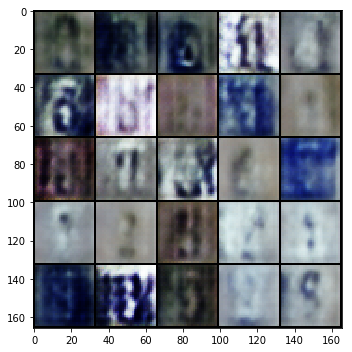

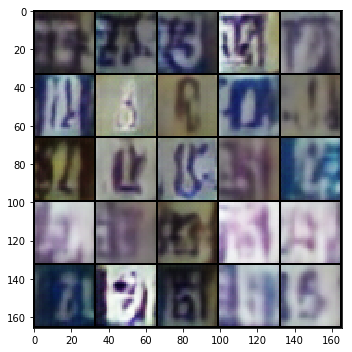

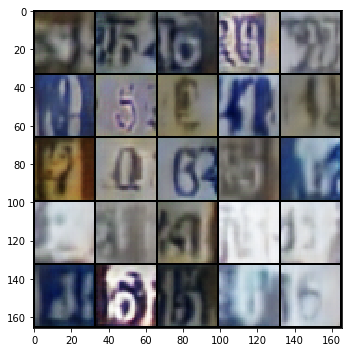

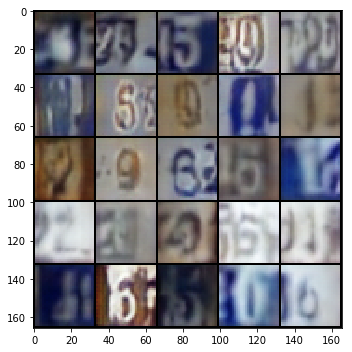

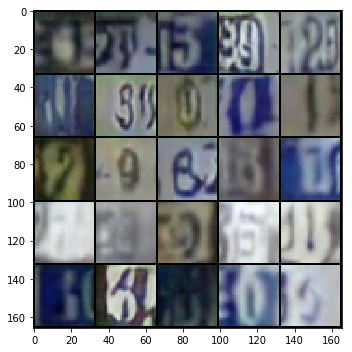

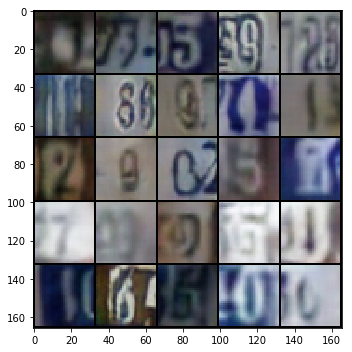

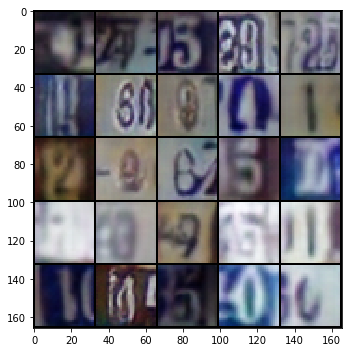

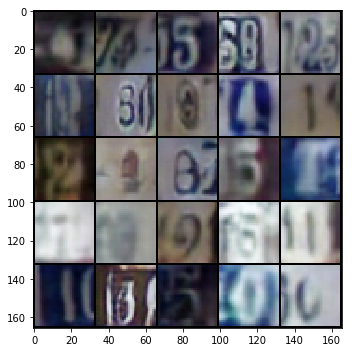

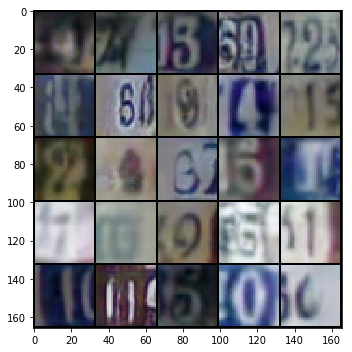

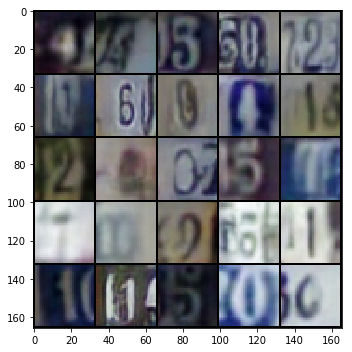

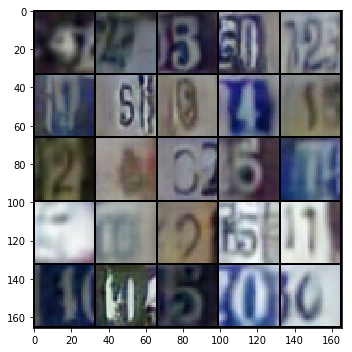

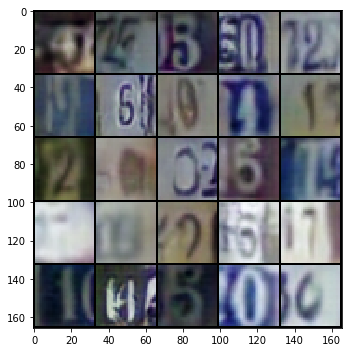

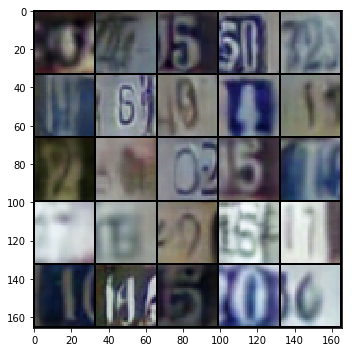

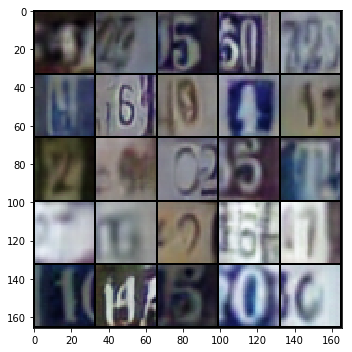

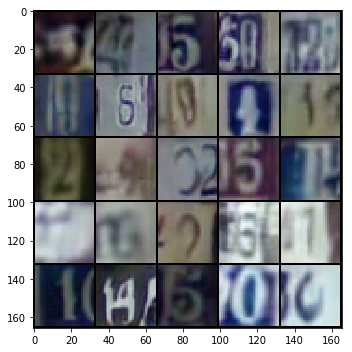

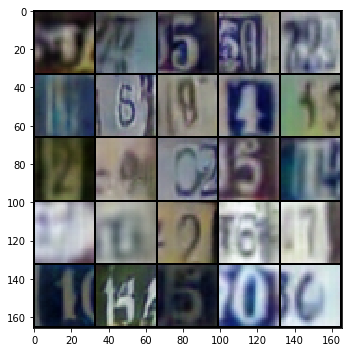

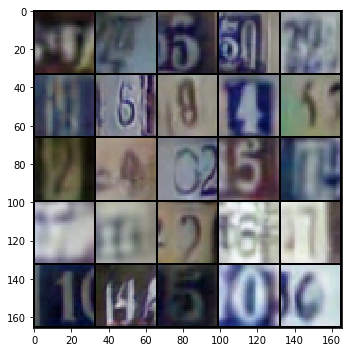

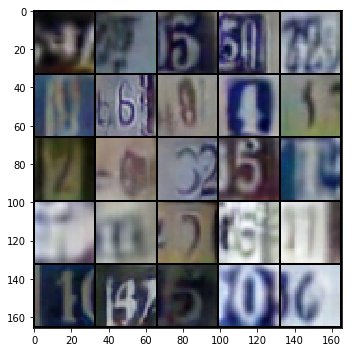

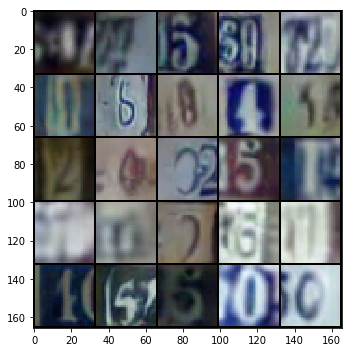

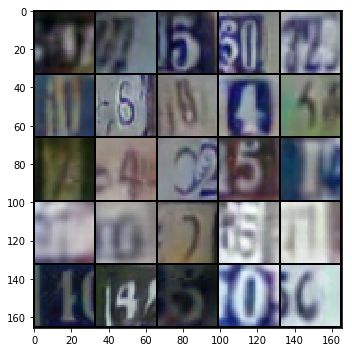

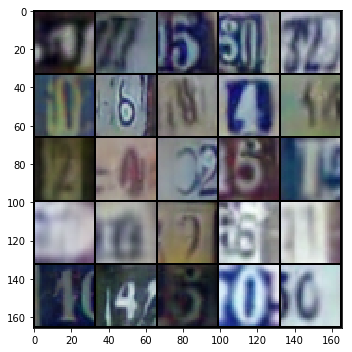

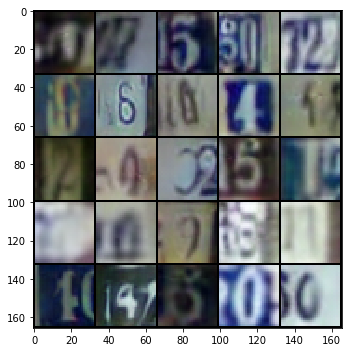

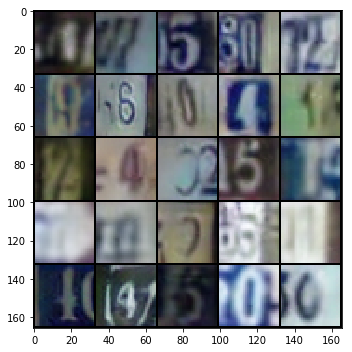

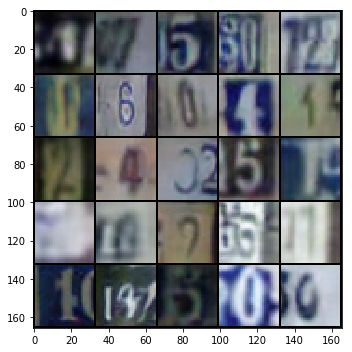

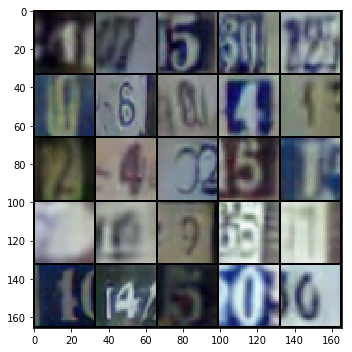

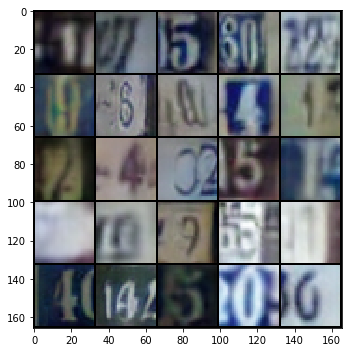

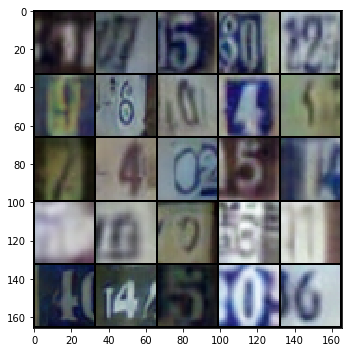

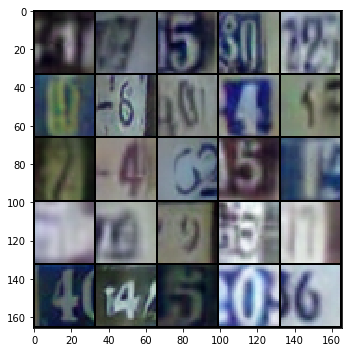

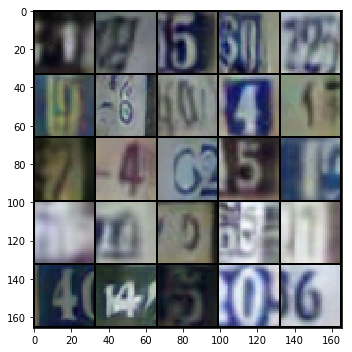

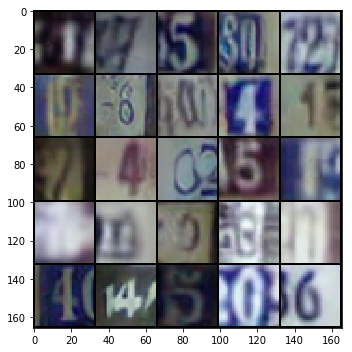

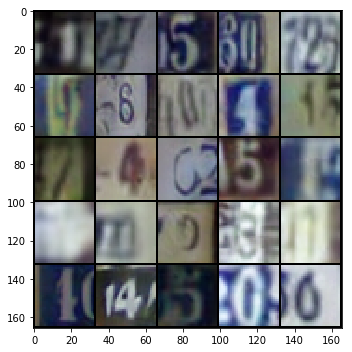

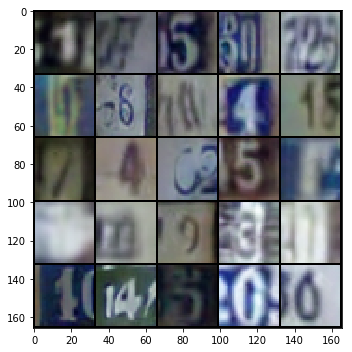

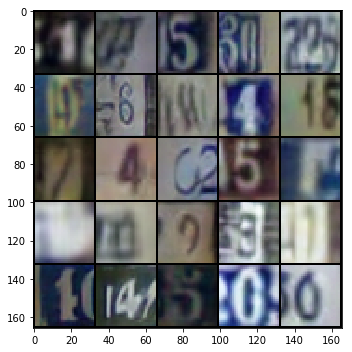

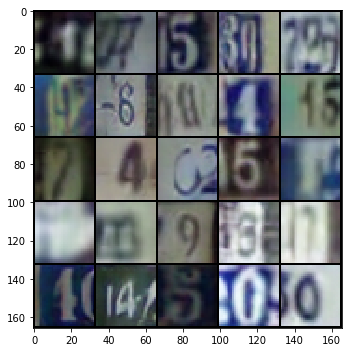

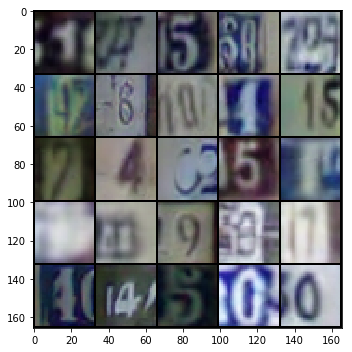

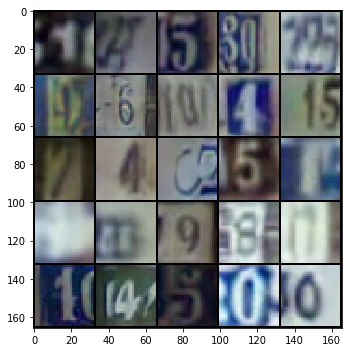

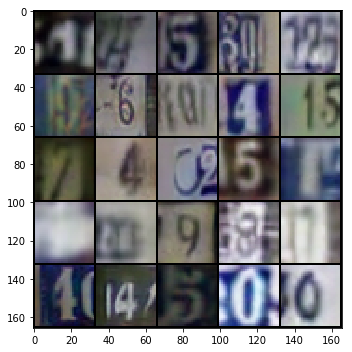

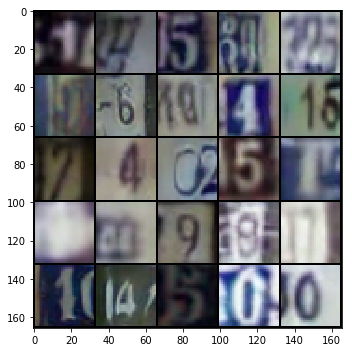

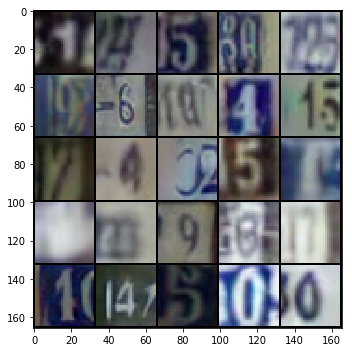

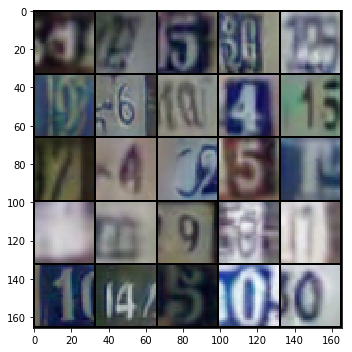

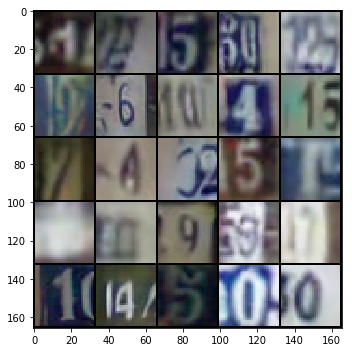

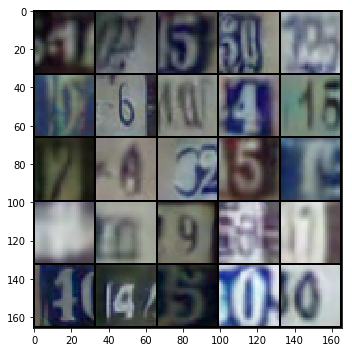

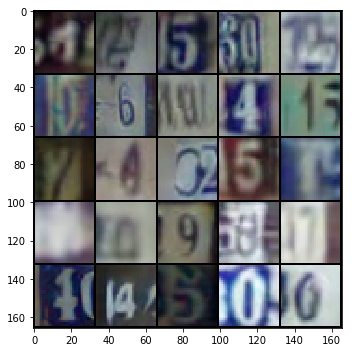

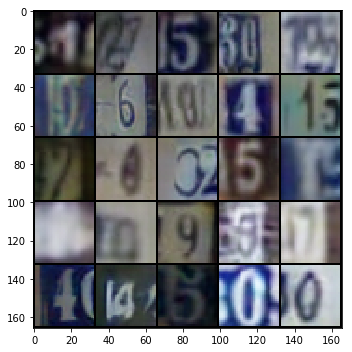

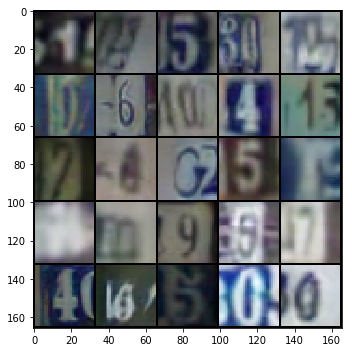

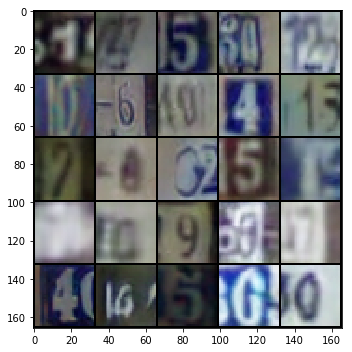

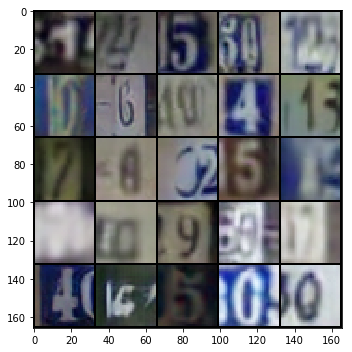

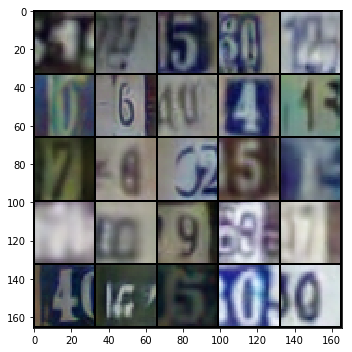

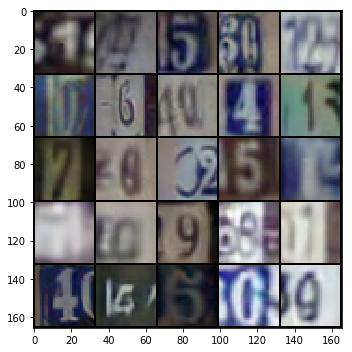

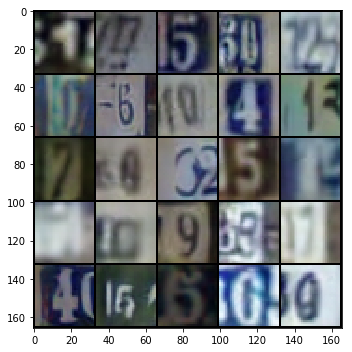

In [14]:
#REFERENCE : https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

img_path="GAN_img/"
# Training Loop
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    
    fake = netG(fixed_noise).detach().cpu()
    show(make_grid(fake, padding=1,normalize=True,nrow=5),epoch,img_path)
    
    torch.save(netG.state_dict(), 'gan_gen.torch')
    torch.save(netD.state_dict(), 'gan_dis.torch')

In [15]:
#test

for i, batch in enumerate(test_loader):
    real = batch
    noise = torch.randn(real.shape[0], 100, 1, 1, device=device)
    fake = netG(noise) 

    netD.eval()

    print(netD.forward(real.to(device)).mean())
    print(netD.forward(fake.to(device)).mean())

    if i == 5:
        break

tensor(0.2315, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0593, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2660, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0902, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0844, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2115, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0433, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1472, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0796, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.1710, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0351, device='cuda:0', grad_fn=<MeanBackward1>)
